In [2]:
import gzip
import pandas as pd
from collections import defaultdict
import numpy as np
import pandas as pd
import gzip
import json
from surprise import Dataset, SVD,Reader
from surprise.model_selection import GridSearchCV

In [3]:
with gzip.open("train.json.gz", 'rt', encoding='utf-8') as gzip_file:
    for line in gzip_file:
        train = json.loads(line)

In [4]:
# create a list of userid, asin, rating pair from train data
user_asin_rate = []
for i in range(len(train)):
    user_asin_rate.append([train[i]['reviewerID'],train[i]['asin'],train[i]['overall']])

In [67]:
with gzip.open("val.json.gz", 'rt', encoding='utf-8') as gzip_file:
    for line in gzip_file:
        val = json.loads(line)

In [69]:
val_user_asin_rate = []
for i in range(len(val)):
    val_user_asin_rate.append([val[i]['reviewerID'],val[i]['asin'],val[i]['overall']])

In [70]:
# combine train and val 
user_asin_rate.extend(val_user_asin_rate)

In [72]:
df=pd.DataFrame(user_asin_rate,columns=['userid','asin','rating'])

In [75]:
# Use movielens-100K

data = Dataset.load_from_df(df,reader=Reader(rating_scale=(1, 5)))

param_grid = {"n_factors":[3],"n_epochs": [20],"init_std_dev":[0.0001], 
              "lr_all":[ 0.006], "reg_all": [0.013, 0.0127]}
            #"lr_bu":[0.003], "lr_bi":[0.01], "lr_pu":[0.009], "lr_qi":[0.003],"reg_all": [0.0001]}
gs = GridSearchCV(SVD, param_grid, measures=["mse"], cv=4)

gs.fit(data)

# best RMSE score
print(gs.best_score["mse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["mse"])

1.530642975841023
{'n_factors': 3, 'n_epochs': 20, 'init_std_dev': 0.0001, 'lr_all': 0.006, 'reg_all': 0.013}


In [84]:
with gzip.open("test.json.gz", 'rt', encoding='utf-8') as gzip_file:
    for line in gzip_file:
        test = json.loads(line)
# create a list of userid, asin, rating pair from train data
testset = []
for i in range(len(test)):
    testset.append([test[i]['reviewerID'],test[i]['asin'],test[i]['overall']])
testset = pd.DataFrame(testset,columns=['userid','asin','rating'])
data_test = Dataset.load_from_df(testset,reader=Reader(rating_scale=(1, 5)))

In [92]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator["mse"]
algo.fit(data.build_full_trainset())
testset["prediction"] = testset.apply(lambda x: algo.predict(x.userid, x.asin).est, axis=1)

In [93]:
(testset.rating-testset.prediction).apply(lambda x: x**2).mean()

1.4994362757915214

In [94]:
testset["claasification"]= testset.prediction.apply(lambda x: round(x))
testset["rating"]=testset["rating"].astype(int)

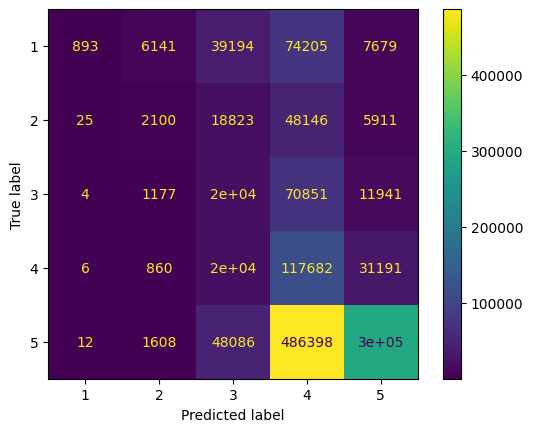

In [95]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(testset.rating, testset.claasification,labels=[1,2,3,4,5],normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=[1,2,3,4,5])
#save cmd plot 
cmd.plot()
cmd.figure_.savefig('latent.png',dpi=300)

In [96]:
#add index to cm
cm_df = pd.DataFrame(cm)
cm_df.columns = [1,2,3,4,5]
cm_df.index = [1,2,3,4,5]
cm_df.to_csv("latent_cm.csv")

In [97]:
# cm accuracy = diagonal/total
cm_df.values.diagonal().sum()/cm_df.values.sum()

0.3336331684367637